# Extrapolation: HVAC Type

### Importing Packages

In [2]:
import pandas as pd
import numpy as np

import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Importing Simulation and HVAC Data

In [3]:
# Import simulation data
simdata = pd.read_csv("MidPackage_RetrofitResults.csv")
# Import HVAC data
hvac = pd.read_csv("LA_HVAC_results.csv")
print('Pre-merge:','\n',simdata.shape, '\n', hvac.shape)

# Merge dataframes
merged = pd.merge(simdata, hvac, left_on="ubid", right_on="LA_bid")
print("Post-merge:","\n", merged.shape)
#merged.head()

# Selecting only buidlings from Simulation
merged = merged[merged['retrofit package name'] == "ECM Package 1"]

# Renaming some columns
merged = merged.rename(columns={"building type": "building_type", 
                                "year built (year)": "year_built", 
                                "total floor area (m2)": "floor_area", 
                                "baseline annual site energy use intensity (kWh/m2)": "site_eui",
                                "baseline annual water for water systems (m3/m2)": "annual_water"})

# Changing units
merged["annual_water"] = merged["annual_water"]*merged["floor_area"]
merged["annual_water"] = merged["annual_water"]*264.172
merged["floor_area"] = merged["floor_area"]*10.7639
merged["annual_water"] = merged["annual_water"]/merged["floor_area"]

Pre-merge: 
 (486, 105) 
 (243, 5)
Post-merge: 
 (486, 110)


### Importing EBEWE Data

In [4]:
EBEWE_buildings = pd.read_csv("Building_Data.csv") 
EBEWE_buildings = EBEWE_buildings.replace('Not Available',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace('',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace(' ',np.NaN)

# Keeping only unqiue buidling IDs
unique = EBEWE_buildings.drop_duplicates('BUILDING.ID') 

# Renaming some columns
unique = unique.rename(columns={"YEAR.BUILT": "year_built", 
                                "GROSS.BUILDING.FLOOR.AREA": "floor_area", 
                                "SITE.EUI": "site_eui",
                                "TOTAL.WATER.USE": "annual_water"})
# Changing units
unique["annual_water"] = (unique["annual_water"]*1000)/unique['floor_area']

unique.shape

(11724, 36)

## HVAC Type

In [5]:
merged["HVAC_system_type"].unique()

array(['central chiller + boiler (VAV with reheat)',
       'split system air conditioner+gas furnace - each zone',
       'Packaged rooftop (VAV with reheat)-each story + boiler',
       'packaged rooftop air conditioner+gas furnace - each zone'],
      dtype=object)

In [7]:
# Subset dataframe
merged_ht = merged[["HVAC_system_type","building_type","year_built","floor_area","site_eui", "annual_water"]]
# Reduce number of building types
merged_ht = merged_ht.replace({"Multi Family House": "multi_family",
                               "Medium Retail": "medium_retail", 
                               "Small Retail" : "small_retail", 
                               "Large Office" : "large_office", 
                               "Medium Office": "medium_office",
                               "Small Office" : "medium_office"})


merged_ht = merged_ht.replace({"Packaged rooftop (VAV with reheat)-each story + boiler": 1, 
                               "central chiller + boiler (VAV with reheat)": 2, 
                               "packaged rooftop air conditioner+gas furnace - each zone": 3,
                               "split system air conditioner+gas furnace - each zone": 4})


# Get HVAC type indicator variables and rename them
merged_ht = pd.get_dummies(merged_ht) 
#merged_ht = merged_ht.rename(columns={"HVAC_system_type_Packaged rooftop (VAV with reheat)-each story + boiler": "rooftop_story", 
#                                      "HVAC_system_type_central chiller + boiler (VAV with reheat)": "central_chiller", 
#                                      "HVAC_system_type_packaged rooftop air conditioner+gas furnace - each zone": "rooftop_zone",
#                                      "HVAC_system_type_split system air conditioner+gas furnace - each zone": "split_system"})

# Get Year built indicators
merged_ht["pre1970"] = 0
merged_ht.loc[(merged_ht['year_built'] < 1970), 'pre1970'] = 1
merged_ht["in1970s"] = 0
merged_ht.loc[(merged_ht['year_built'] >= 1970) & (merged_ht['year_built'] < 1980), 'in1970s'] = 1
merged_ht["in1980s"] = 0
merged_ht.loc[(merged_ht['year_built'] >= 1980) & (merged_ht['year_built'] < 1990), 'in1980s'] = 1
merged_ht["post1990"] = 0
merged_ht.loc[(merged_ht['year_built'] > 1990), 'post1990'] = 1

# Scale contious variables
scaler = MinMaxScaler()
scaler.fit(merged_ht[["floor_area","site_eui","annual_water"]])
merged_ht[["floor_area","site_eui","annual_water"]] = scaler.transform(merged_ht[["floor_area","site_eui","annual_water"]])

merged_ht.head()

,HVAC_system_type,year_built,floor_area,site_eui,annual_water,building_type_large_office,building_type_medium_office,building_type_medium_retail,building_type_multi_family,building_type_small_retail,pre1970,in1970s,in1980s,post1990
1,2,1984,0.130515,0.437533,0.000007,1,0,0,0,0,0,0,1,0
3,4,1971,0.028289,0.134163,0.790009,0,0,0,1,0,0,1,0,0
5,2,1981,0.060037,0.480487,0.000008,1,0,0,0,0,0,0,1,0
7,1,1984,0.027549,0.269347,0.000007,0,1,0,0,0,0,0,1,0
9,4,1969,0.027454,0.137448,0.803214,0,0,0,1,0,1,0,0,0


In [8]:
#simdata = merged[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]
x = merged_ht.drop(columns=["HVAC_system_type", "year_built"])
y = merged_ht["HVAC_system_type"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [9]:
X_train.columns

Index(['floor_area', 'site_eui', 'annual_water', 'building_type_large_office',
       'building_type_medium_office', 'building_type_medium_retail',
       'building_type_multi_family', 'building_type_small_retail', 'pre1970',
       'in1970s', 'in1980s', 'post1990'],
      dtype='object')

In [10]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train,y_train)
neigh.score(X_test, y_test)

0.9876543209876543

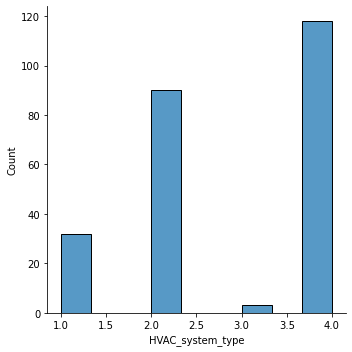

In [11]:
import seaborn as sns
sns.displot(merged_ht, x="HVAC_system_type")

In [13]:
# Select only medium multi-family 
e_allthree = unique[(unique["PROPERTY.TYPE"]=="Multifamily Housing") | 
                    (unique["PROPERTY.TYPE"]=="Office") | 
                    (unique["PROPERTY.TYPE"]=="Retail Store")]

e_allthree = e_allthree.replace({"Multifamily Housing": "multi_family",
                                 "Office": "office", 
                                 "Retail Store" : "retail"})

e_allthree = e_allthree[["BUILDING.ID", "PROPERTY.TYPE", "year_built", "floor_area", "annual_water", "site_eui"]]
e_allthree = e_allthree.rename(columns={"PROPERTY.TYPE": "building_type"})

e_allthree = pd.get_dummies(e_allthree) 
                                        
e_allthree["pre1970"] = 0
e_allthree.loc[(e_allthree['year_built'] < 1970), 'pre1970'] = 1
e_allthree["in1970s"] = 0
e_allthree.loc[(e_allthree['year_built'] >= 1970) & (e_allthree['year_built'] < 1980), 'in1970s'] = 1
e_allthree["in1980s"] = 0
e_allthree.loc[(e_allthree['year_built'] >= 1980) & (e_allthree['year_built'] < 1990), 'in1980s'] = 1
e_allthree["post1990"] = 0
e_allthree.loc[(e_allthree['year_built'] > 1990), 'post1990'] = 1


e_allthree["building_type_medium_office"] = 0
e_allthree.loc[(e_allthree['building_type_office'] == 1) & 
               (e_allthree['floor_area'] < 100000), 'building_type_medium_office'] = 1
e_allthree["building_type_large_office"] = 0
e_allthree.loc[(e_allthree['building_type_office'] == 1) & 
               (e_allthree['floor_area'] > 100000), 'building_type_large_office'] = 1

e_allthree["building_type_small_retail"] = 0
e_allthree.loc[(e_allthree['building_type_retail'] == 1) & 
               (e_allthree['floor_area'] < 50000), 'building_type_small_retail'] = 1
e_allthree["building_type_medium_retail"] = 0
e_allthree.loc[(e_allthree['building_type_retail'] == 1) & 
               (e_allthree['floor_area'] > 500000), 'building_type_large_office'] = 1
                
scaler = MinMaxScaler()
scaler.fit(e_allthree[["floor_area","site_eui","annual_water"]])
e_allthree[["floor_area","site_eui","annual_water"]] = scaler.transform(e_allthree[["floor_area","site_eui","annual_water"]])

e_allthree = e_allthree.dropna()

In [14]:
e_allthree['predicted_HVAC_type'] = neigh.predict(e_allthree[['floor_area', 'site_eui', 'annual_water', 'building_type_large_office',
       'building_type_medium_office', 'building_type_medium_retail',
       'building_type_multi_family', 'building_type_small_retail', 'pre1970',
       'in1970s', 'in1980s', 'post1990']])

pd.set_option('display.max_rows', 500)
e_allthree[0:500]

,BUILDING.ID,year_built,floor_area,annual_water,site_eui,building_type_multi_family,building_type_office,building_type_retail,pre1970,in1970s,in1980s,post1990,building_type_medium_office,building_type_large_office,building_type_small_retail,building_type_medium_retail,predicted_HVAC_type
1,474608916272,1983.0,0.004551,2.375991e-03,0.000361,1,0,0,0,0,1,0,0,0,0,0,4
5,471068915912,1981.0,0.011813,1.057330e-03,0.000282,1,0,0,0,0,1,0,0,0,0,0,4
32,475197914051,1988.0,0.006835,1.367471e-03,0.000382,1,0,0,0,0,1,0,0,0,0,0,4
34,474880915329,1978.0,0.005817,8.718908e-04,0.000087,1,0,0,0,1,0,0,0,0,0,0,4
42,473333914129,1964.0,0.007981,1.820617e-03,0.000366,1,0,0,1,0,0,0,0,0,0,0,4
57,474512915540,1984.0,0.006289,1.152261e-03,0.000346,1,0,0,0,0,1,0,0,0,0,0,4
65,476741913828,1986.0,0.007454,1.085433e-03,0.000086,1,0,0,0,0,1,0,0,0,0,0,4
79,478669911672,2003.0,0.005917,3.498993e-04,0.000404,0,0,1,0,0,0,1,0,0,1,0,4
103,477465912352,1979.0,0.009671,5.999915e-05,0.000149,0,1,0,0,1,0,0,1,0,0,0,1
113,112217100628,1951.0,0.032302,6.648282e-04,0.000153,1,0,0,1,0,0,0,0,0,0,0,4


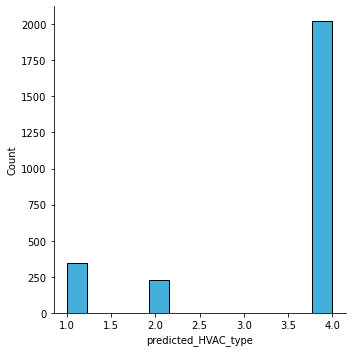

In [18]:
import seaborn as sns
sns.displot(e_allthree, x="predicted_HVAC_type", color="#45afdcff", alpha=1)

In [255]:
hvac_type_data = e_allthree[["BUILDING.ID", "predicted_HVAC_type"]]
hvac_type_data.to_csv("hvac_type_data.csv", index=False)